# asterism - 1 Convert grid to dataframe

In [1]:
import os
import random
import time

import corner
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cmcrameri import cm

In [2]:
# Define constants
SUNnumax = 3090

In [3]:
# Define user input
gridname = "chiara"
gridpath = "/home/amalie/Nextcloud/projects/grids/Garstec_AS09_chiara.hdf5"
outputpath = "./dfs/"
outputfile = "chiara_AS09_NN.csv"

headers = [
    "massini",
    "zini",
    "yini",
    "alphaMLT",
    "age",
    "TAMS",
    "radPhot",
    "LPhot",
    "Teff",
    "zsur",
    "numax",
    "dnufit",
]

nmin = 1
nmax = 15

In [4]:
grid = h5py.File(gridpath, "r")
print(list(grid["grid/tracks/track00001"]))

['BP_GAIA', 'FeH', 'FeHini', 'G_GAIA', 'LPhot', 'MMaxNucE', 'Mbcz', 'Mcore', 'McoreX', 'MeH', 'MeHini', 'PS', 'RMaxNucE', 'RP_GAIA', 'Rbcz', 'Rcore', 'RcoreX', 'TAMS', 'Teff', 'ZAMSLPhot', 'ZAMSTeff', 'age', 'alphaFe', 'alphaMLT', 'd02fit', 'd02mean', 'dage', 'dif', 'dnuAsf', 'dnuSer', 'dnufit', 'dnufitMos12', 'dnuscal', 'epsfit', 'epsfitMos12', 'errflagSer', 'eta', 'fdnuAsf', 'fdnuSer', 'gcut', 'logg', 'massfin', 'massini', 'modnum', 'name', 'numax', 'numaxAsf', 'nummodSer', 'osc', 'osckey', 'ove', 'radPhot', 'radTot', 'rho', 'rhocen', 'tau0', 'taubcz', 'tauhe', 'volume_weight', 'xcen', 'xini', 'xsur', 'ycen', 'yini', 'ysur', 'zcen', 'zini', 'zsur']


In [5]:
def track_df_gen(
    grid: h5py.File,
    track_ids: list[str, ...],
    headers: list[str, str, str] = ["age", "Teff", "LPhot"],
):
    i = 0
    for track_id in track_ids:
        track = grid["grid/tracks/track" + track_id]

        track_array = np.full(len(track[headers[0]]), int(track_id))

        for header in headers:
            track_array = np.column_stack((track_array, np.array(track[header])))

        if i == 0:
            tracks_array = track_array
            i = 1
        else:
            tracks_array = np.vstack((tracks_array, track_array))

    return pd.DataFrame(tracks_array, columns=["track_id"] + headers)

## Make overview plots

In [6]:
def plot_hroverview(
    grid: h5py.File,
    headers: list[str, str, str] = ["age", "Teff", "LPhot", "TAMS"],
    nosamples: int = 50,
    withincurrentuniverse: bool = False,
    seed: int = 42,
):
    random.seed(seed)
    track_ids = [
        track_name.replace("track", "")
        for track_name in random.sample(list(grid["grid/tracks"]), nosamples)
    ]

    tracks_df = track_df_gen(grid, track_ids, headers)

    if withincurrentuniverse:
        mask = (tracks_df["age"] <= 14e3) & (tracks_df["TAMS"] >= 0)
        tracks_df = tracks_df[mask]

    plt.figure(figsize=(10, 10))
    plt.scatter(
        np.log10(tracks_df[headers[1]]),
        np.log10(tracks_df[headers[2]]),
        c=tracks_df[headers[0]] / 1000,
        cmap=cm.buda,
    )
    plt.xlabel(headers[1])
    plt.ylabel(headers[2])

    cbar = plt.colorbar()
    cbar.set_label(f"{headers[0]}")

    plt.gca().invert_xaxis()

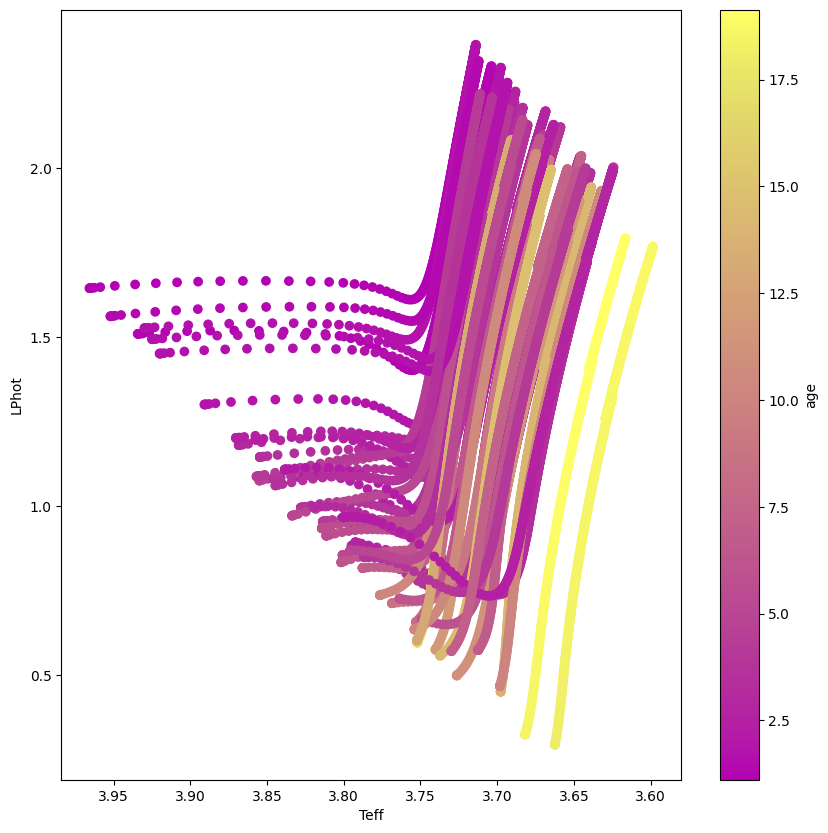

In [7]:
plot_hroverview(grid)

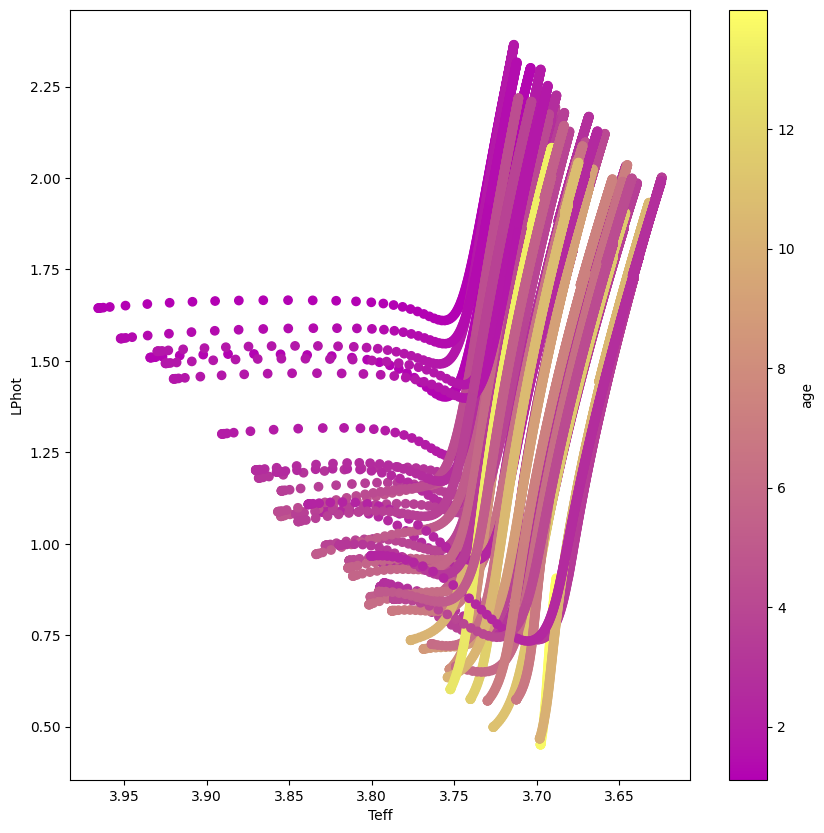

In [8]:
plot_hroverview(grid, withincurrentuniverse=True)

## Make the full conversion

In [9]:
track_ids = [
    track_name.replace("track", "") for track_name in list(grid["grid/tracks"])
]

tracks_df = track_df_gen(grid, track_ids, headers)

# Masks
mask = (
    (tracks_df["dnufit"] != 0) & (tracks_df["age"] <= 14e3) & (tracks_df["TAMS"] >= 0)
)

tracks_df = tracks_df[mask]
tracks_df = tracks_df.drop(columns="TAMS")

tracks_df["age"] = tracks_df["age"] / 1000
tracks_df["numax"] = tracks_df["numax"] * SUNnumax

In [10]:
tracks_df.describe()

,track_id,massini,zini,yini,alphaMLT,age,radPhot,LPhot,Teff,zsur,numax,dnufit
count,6.771650e+06,6.771650e+06,6.771650e+06,6.771650e+06,6.771650e+06,6.771650e+06,6.771650e+06,6.771650e+06,6.771650e+06,6.771650e+06,6.771650e+06,6.771650e+06
mean,5.002026e+03,1.155651e+00,6.772879e-03,2.837900e-01,1.916148e+00,5.294179e+00,1.060584e+01,6.608272e+01,4.969482e+03,6.799301e-03,7.130037e+01,6.546509e+00
std,2.885572e+03,2.060566e-01,8.698801e-03,3.731470e-02,2.302853e-01,3.304654e+00,4.201935e+00,4.388464e+01,4.130799e+02,8.724981e-03,1.012937e+02,6.720687e+00
min,1.000000e+00,7.000000e-01,9.149300e-05,2.200159e-01,1.500049e+00,8.274848e-01,2.011948e+00,2.095283e+00,3.787317e+03,9.149309e-05,1.049778e+01,1.862004e+00
25%,2.509000e+03,9.900000e-01,9.383240e-04,2.514764e-01,1.720020e+00,2.615148e+00,7.209582e+00,2.988973e+01,4.704701e+03,9.422995e-04,1.935750e+01,2.655752e+00
50%,5.001000e+03,1.164000e+00,3.185024e-03,2.832068e-01,1.923877e+00,4.337668e+00,1.087578e+01,5.882141e+01,4.971186e+03,3.202643e-03,3.238134e+01,3.919724e+00
75%,7.499000e+03,1.332000e+00,9.344890e-03,3.158020e-01,2.116699e+00,7.356363e+00,1.409991e+01,9.513856e+01,5.193172e+03,9.375417e-03,7.155169e+01,7.270113e+00
max,9.998000e+03,1.500000e+00,5.985032e-02,3.499921e-01,2.299902e+00,1.400000e+01,1.898128e+01,2.508199e+02,9.936561e+03,5.996177e-02,7.642789e+02,4.116145e+01


In [11]:
def plot_corner_overview(
    tracks_df: pd.DataFrame,
    gridname: str,
    plotname: str,
    cols: list[str, ...] = ["massini", "zini", "yini", "alphaMLT", "age"],
):
    sns.set(font_scale=2)
    sns.set_style(style="white")
    sns.set_palette("crest")

    ax = sns.pairplot(
        tracks_df[cols].sample(frac=0.001),
        diag_kind="hist",
    )
    ax.fig.suptitle(f"{gridname} {plotname}", y=1.02)

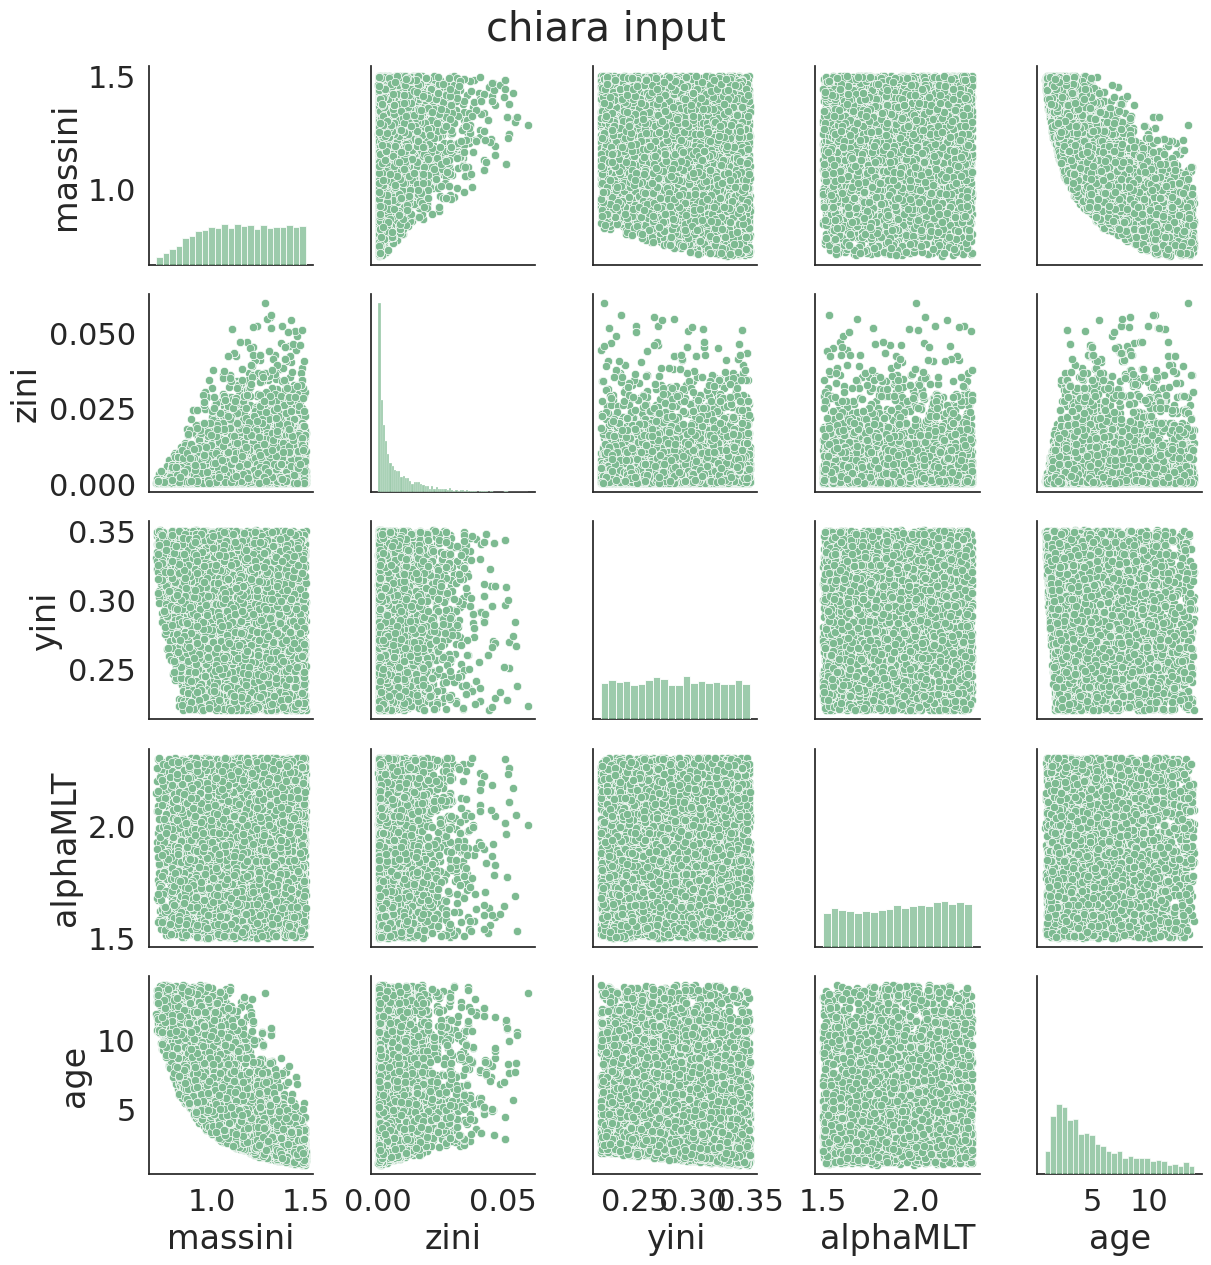

In [12]:
plot_corner_overview(tracks_df, gridname, "input")

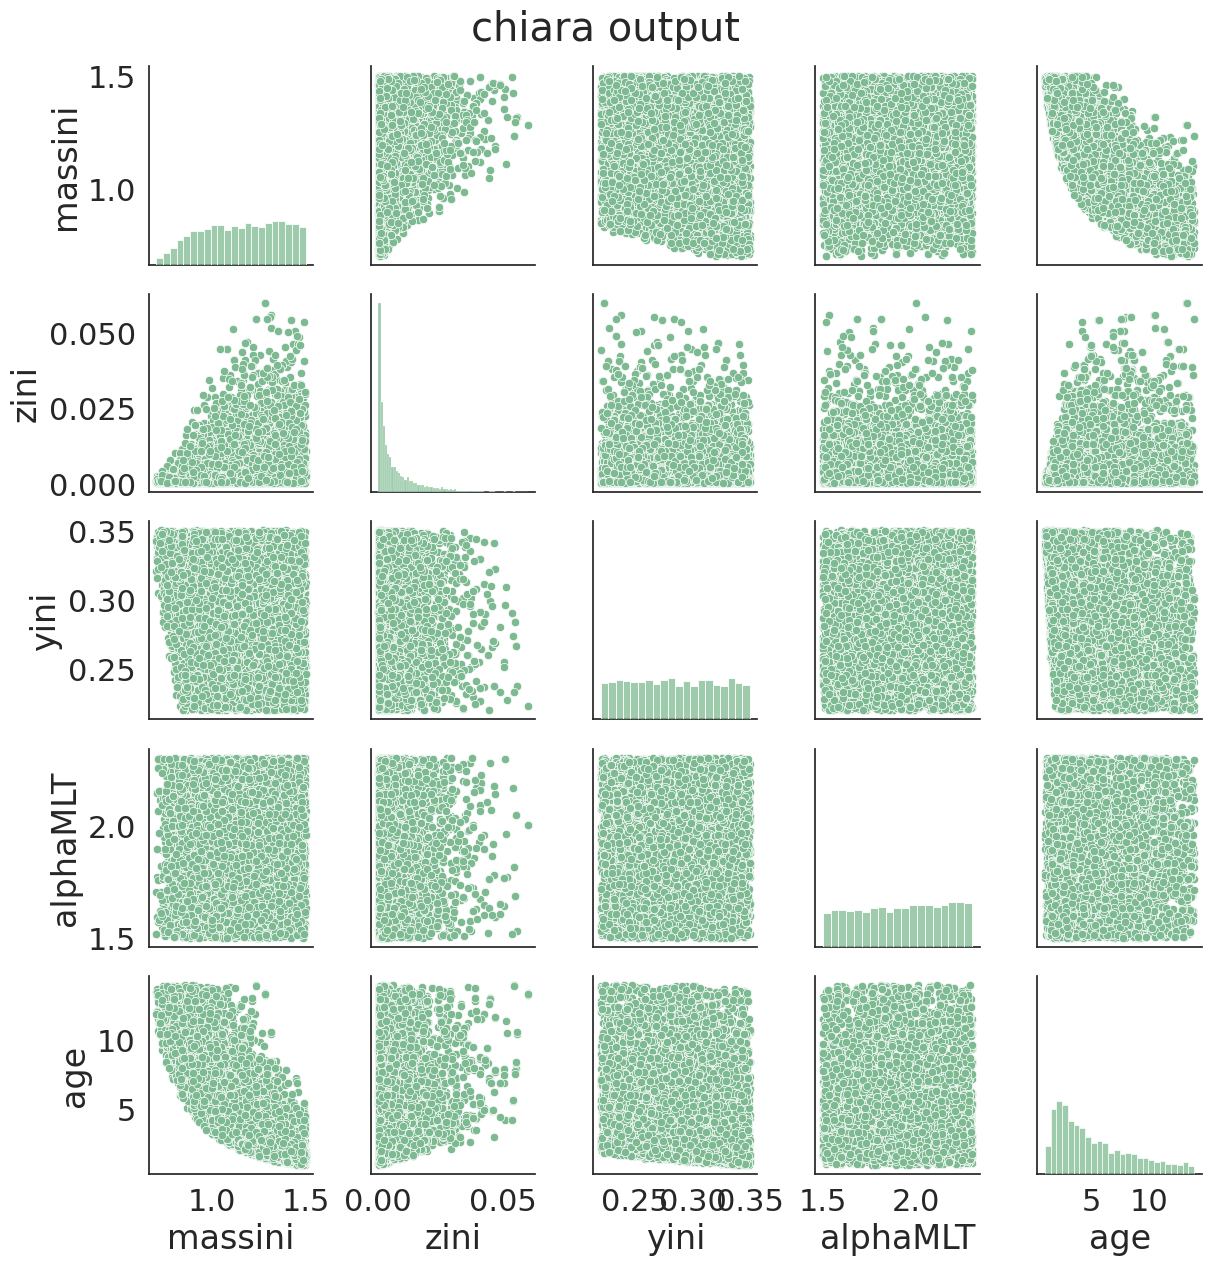

In [13]:
plot_corner_overview(tracks_df, gridname, "output")

# Grid loading and trimming

In [14]:
def plot_nrange_for_singletrack(
    grid: h5py.File,
    track_id: str,
    max_age: float = np.inf,
    n_min: int = 15,
    n_max: int = 25,
    padded: bool = False,
):
    plt.figure(figsize=(20, 10))

    track = grid["grid/tracks/track" + track_id]
    age = track["age"]
    points = np.array(age)[np.where(np.array(age) <= max_age)[0]]

    first_point = points[0]
    last_point = points[-1]

    osckeys = track["osckey"]
    dnufits = track["dnufit"]

    i = 0
    for point in points:
        n_vals = osckeys[i][1][np.where(osckeys[i][0] == 0)[0]]
        nu_vals = list(track["osc"][i][0][np.where(osckeys[i][0] == 0)])

        n_upper = n_vals[-1]
        n_lower = n_vals[0]

        plt.plot(np.full(2, point) / 1000, np.array([n_upper, n_lower]), color="blue")
        if padded:
            if n_upper < n_max:
                dnufit = dnufits[i]
                nu_max = nu_vals[-1]
                n_diff = n_max - n_upper
                try:
                    nu_upper_pad = np.arange(
                        nu_max + dnufit, nu_max + (dnufit * (n_diff + 1)), dnufit
                    )
                except:
                    nu_upper_pad = np.full(n_diff, nu_max)
                    n_upper = n_max
                nu_vals = nu_vals + nu_upper_pad.tolist()
                plt.plot(
                    np.full(2, point) / 1000,
                    np.array([n_upper, n_max]),
                    color="red",
                    linestyle="dashed",
                )

            if n_lower > n_min:
                dnufit = dnufits[i]
                nu_min = nu_vals[0]
                n_diff = n_lower - n_min
                try:
                    nu_lower_pad = np.arange(nu_min - (n_diff * dnufit), nu_min, dnufit)
                except:
                    nu_lower_pad = np.full(n_diff, nu_min)
                    n_lower = n_min
                nu_vals = nu_lower_pad.tolist() + nu_vals
                plt.plot(
                    np.full(2, point) / 1000,
                    np.array([n_min, n_lower]),
                    color="red",
                    linestyle="dashed",
                )

        i += 1

        plt.axhline(n_min, linestyle="dashed", color="black")
        plt.axhline(n_max, linestyle="dashed", color="black")

    plt.xlabel("age, Gyr")
    plt.ylabel("radial orders (l=0) present")
    plt.title(f"n range for track {track_id}: n={i}")

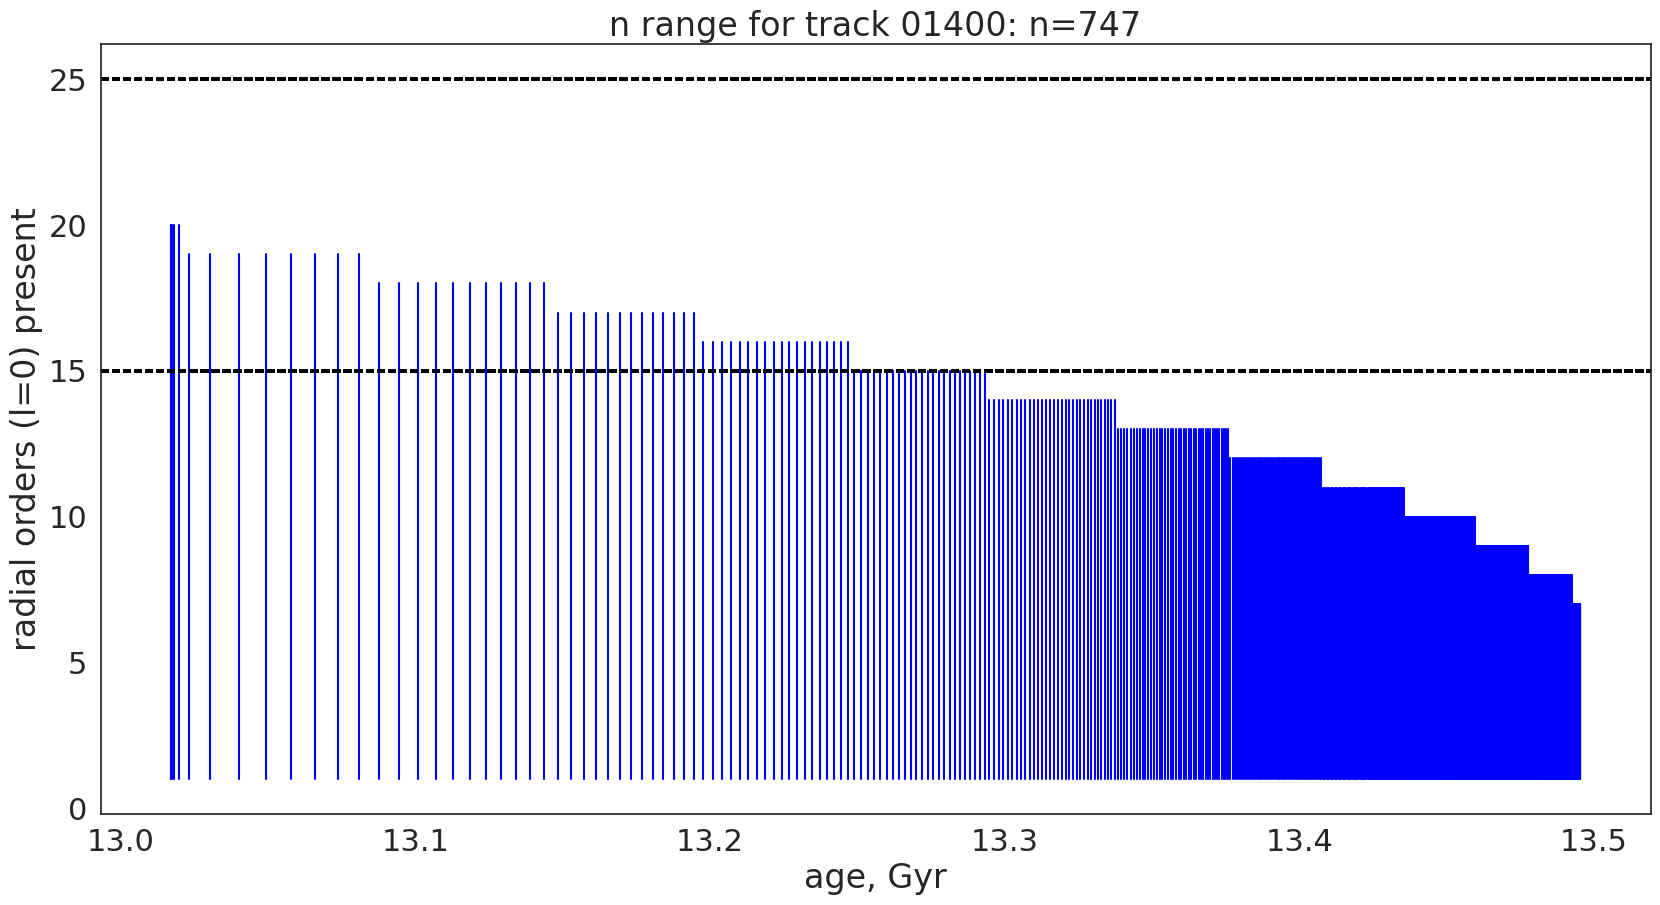

In [15]:
plot_nrange_for_singletrack(grid, "01400")

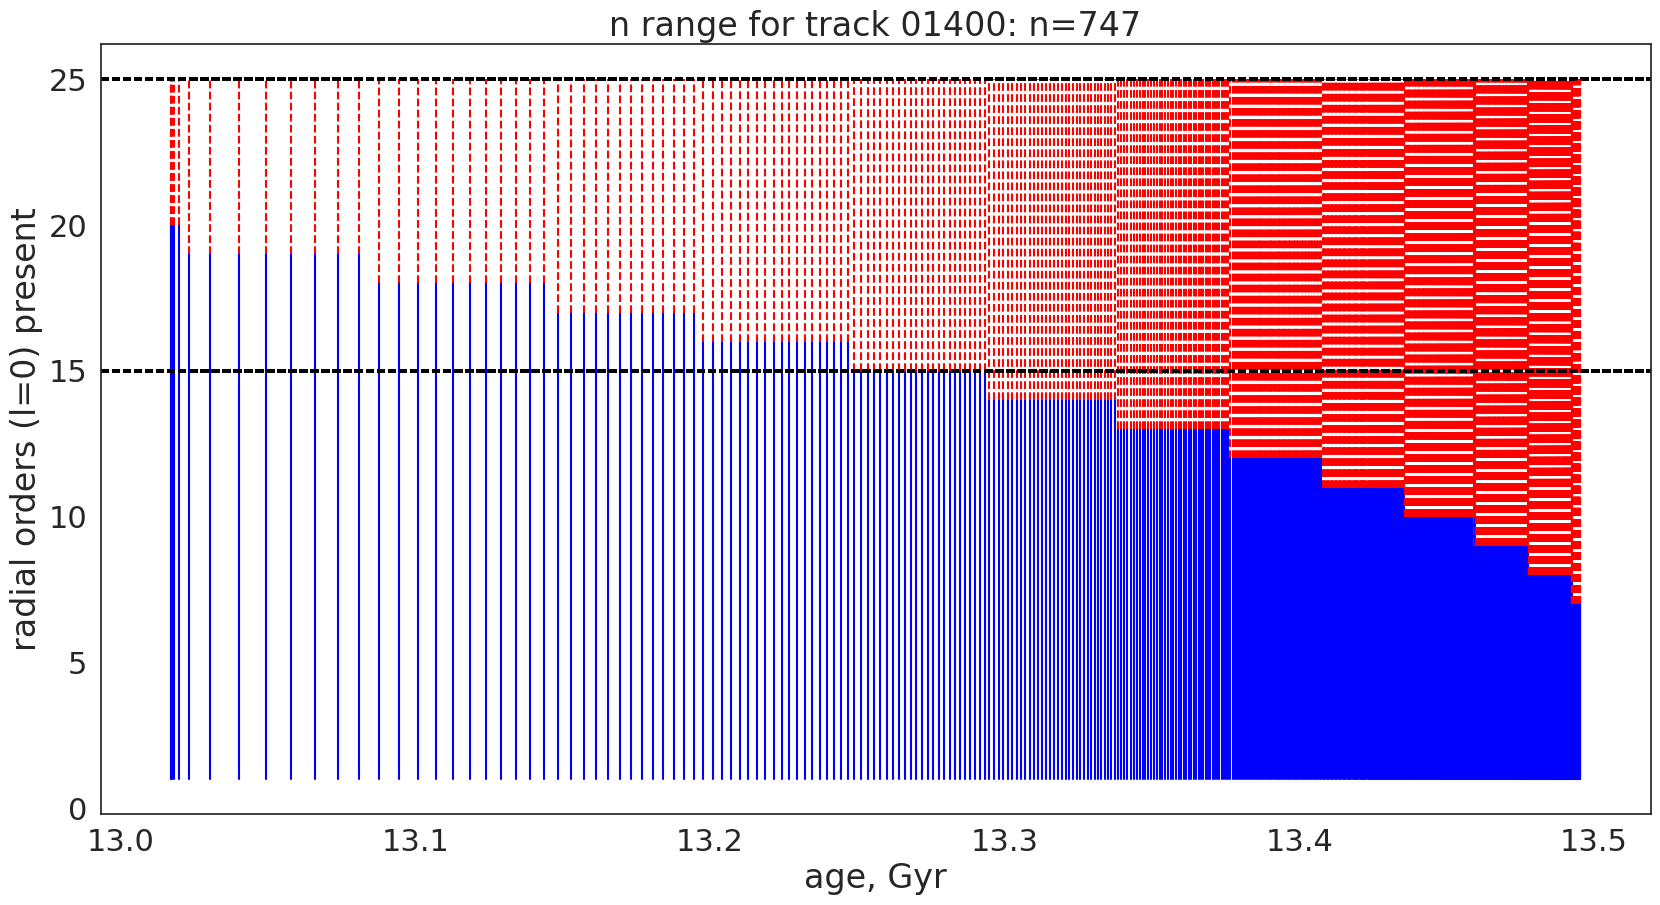

In [16]:
plot_nrange_for_singletrack(grid, "01400", padded=True)

# Convert grid to dataframe

In [16]:
def convert_hdf52df_withmodes(
    grid: h5py.File,
    track_ids: list[str, ...],
    n_min: int = 15,
    n_max: int = 25,
    headers: list[str, ...] = ["age", "Teff", "LPhot"],
):
    """
    Convert garstec hdf5 file (grid) to NN friendly dataframe file for training.

    args:
    grid -- garstec hdf5 out file
    track_ids -- list of track ids (including leading zeros) to iterate over

    kwargs:
    n_min -- lower limit of radial order to load/pad
    n_max -- upper limit of radial order to load/pad
    headers -- relevant headers to include in final dataframe (inputs and outputs for training, typically)

    returns:
    pandas dataframe with columns:
        - ['track_id'] -- integer track id from GARSTEC hdf5 out file, no leading 0s
        - [headers] -- columns for each header defined by 'headers' kwarg
        - [nu_headers] -- columns for mode frequency values for radial orders in range n_min->n_max

    notes:
    - Operates track by track, and fills missing mode freqencies by padding using GARSTEC dnufit.
    - Modes loaded/filled between a min and max radial order. This must be consistent between all dataframe rows.
    - Warning is printed when padding is occuring. This is unexpected behaviour if radial orders between n_min and n_max should be present for all points in the grid.
    """
    nu_headers = [f"nu_0_{n}" for n in range(n_min, n_max + 1)]
    first_switch = 0
    missing = []
    for track_id in track_ids:
        print(str(track_id), end="\r")
        track = grid["grid/tracks/track" + track_id]

        track_array = np.full(len(track[headers[0]]), int(track_id))

        for header in headers:
            track_array = np.column_stack((track_array, np.array(track[header])))

        age = track["age"]

        points = np.array(age)
        try:
            first_point = points[0]
        except IndexError:
            missing.append(track_id)
            continue
        last_point = points[-1]

        osckeys = track["osckey"]
        dnufits = track["dnufit"]

        i = 0
        padding_switch = 0
        for point in points:
            n_vals = osckeys[i][1][np.where(osckeys[i][0] == 0)[0]]
            n_upper = n_vals[-1]
            n_lower = n_vals[0]
            dnufit = dnufits[i]

            nu_vals = list(track["osc"][i][0][np.where(osckeys[i][0] == 0)])
            if n_upper < n_max:
                nu_max = nu_vals[-1]
                n_diff = n_max - n_upper
                try:
                    nu_upper_pad = (np.linspace(1, n_diff, n_diff) * dnufit) + nu_max
                except:
                    nu_upper_pad = np.full(n_diff, nu_max)
                nu_vals = nu_vals + nu_upper_pad.tolist()
                n_upper = n_max
                padding_switch = 1

            if n_lower > n_min:
                nu_min = nu_vals[0]
                n_diff = n_lower - n_min
                try:
                    nu_lower_pad = nu_min - (np.linspace(n_diff, 1, n_diff) * dnufit)
                except:
                    nu_lower_pad = np.full(n_diff, nu_min)
                nu_vals = nu_lower_pad.tolist() + nu_vals
                n_lower = n_min
                padding_switch = 1

            nu_vals = nu_vals[n_min - n_lower : (n_max - n_lower) + 1]

            if i == 0:
                nu_vals_arr = nu_vals
            else:
                nu_vals_arr = np.vstack((nu_vals_arr, nu_vals))
            i += 1

        track_array = np.concatenate((track_array, nu_vals_arr), axis=1)

        if first_switch == 0:
            tracks_array = track_array
            first_switch = 1
        else:
            tracks_array = np.vstack((tracks_array, track_array))

        if padding_switch == 1:
            print(
                f"padding! requested radial order range {n_min}->{n_max} exceeded range present in track{track_id}"
            )

    return pd.DataFrame(tracks_array, columns=["track_id"] + headers + nu_headers), missing

In [18]:
track_ids = [
    track_name.replace("track", "") for track_name in list(grid["grid/tracks"])
]

garstec_df, missing = convert_hdf52df_withmodes(
    grid, track_ids, n_min=nmin, n_max=nmax, headers=headers
)

padding! requested radial order range 1->15 exceeded range present in track00001
padding! requested radial order range 1->15 exceeded range present in track00002
padding! requested radial order range 1->15 exceeded range present in track00003
padding! requested radial order range 1->15 exceeded range present in track00004
padding! requested radial order range 1->15 exceeded range present in track00005
padding! requested radial order range 1->15 exceeded range present in track00006
padding! requested radial order range 1->15 exceeded range present in track00007
padding! requested radial order range 1->15 exceeded range present in track00008
padding! requested radial order range 1->15 exceeded range present in track00009
padding! requested radial order range 1->15 exceeded range present in track00010
padding! requested radial order range 1->15 exceeded range present in track00011
padding! requested radial order range 1->15 exceeded range present in track00012
padding! requested radial or

In [ ]:
print(missing)

### Check dataframe

In [19]:
garstec_df.describe()

,track_id,massini,zini,yini,alphaMLT,age,TAMS,radPhot,LPhot,Teff,...,nu_0_6,nu_0_7,nu_0_8,nu_0_9,nu_0_10,nu_0_11,nu_0_12,nu_0_13,nu_0_14,nu_0_15
count,7.483746e+06,7.483746e+06,7.483746e+06,7.483746e+06,7.483746e+06,7.483746e+06,7.483746e+06,7.483746e+06,7.483746e+06,7.483746e+06,...,7.483746e+06,7.483746e+06,7.483746e+06,7.483746e+06,7.483746e+06,7.483746e+06,7.483746e+06,7.483746e+06,7.483746e+06,7.483746e+06
mean,4.995407e+03,1.125641e+00,7.081989e-03,2.824216e-01,1.916603e+00,6.377355e+03,1.067388e+00,1.044416e+01,6.364577e+01,4.951428e+03,...,4.699938e+01,5.350270e+01,6.004701e+01,6.663866e+01,7.326750e+01,7.992053e+01,8.658997e+01,9.326945e+01,9.995438e+01,1.066419e+02
std,2.883893e+03,2.193117e-01,8.982759e-03,3.725388e-02,2.299017e-01,4.615981e+03,3.882874e-02,4.188160e+00,4.328946e+01,4.101017e+02,...,5.001278e+01,5.668238e+01,6.328804e+01,6.989078e+01,7.651407e+01,8.318713e+01,8.992300e+01,9.671511e+01,1.035556e+02,1.104380e+02
min,1.000000e+00,7.000000e-01,9.149300e-05,2.200159e-01,1.500049e+00,8.274848e+02,1.000000e+00,2.004791e+00,1.868248e+00,3.787317e+03,...,1.297380e+01,1.488410e+01,1.688130e+01,1.878071e+01,2.066056e+01,2.253433e+01,2.440742e+01,2.628050e+01,2.815358e+01,3.001743e+01
25%,2.502000e+03,9.440000e-01,9.819730e-04,2.500879e-01,1.720117e+00,2.752553e+03,1.039768e+00,7.064157e+00,2.809932e+01,4.684124e+03,...,1.806460e+01,2.077430e+01,2.348490e+01,2.622140e+01,2.894370e+01,3.162493e+01,3.429766e+01,3.696977e+01,3.964210e+01,4.231428e+01
50%,4.999000e+03,1.129000e+00,3.382367e-03,2.811438e-01,1.924316e+00,4.822933e+03,1.056742e+00,1.065891e+01,5.587388e+01,4.953846e+03,...,2.732070e+01,3.120100e+01,3.522020e+01,3.924930e+01,4.332440e+01,4.738441e+01,5.139269e+01,5.537189e+01,5.934546e+01,6.331881e+01
75%,7.482000e+03,1.314000e+00,9.776608e-03,3.141516e-01,2.117188e+00,8.881607e+03,1.086883e+00,1.391534e+01,9.166179e+01,5.180804e+03,...,5.200408e+01,5.909087e+01,6.626800e+01,7.366210e+01,8.110417e+01,8.861187e+01,9.617030e+01,1.037011e+02,1.111723e+02,1.185835e+02
max,1.000000e+04,1.500000e+00,5.985032e-02,3.499921e-01,2.299902e+00,2.000000e+04,1.236157e+00,1.898128e+01,2.508199e+02,9.936561e+03,...,2.992412e+02,3.407352e+02,3.815813e+02,4.212481e+02,4.610443e+02,5.013813e+02,5.416722e+02,5.812849e+02,6.210803e+02,6.618406e+02


## Write to file

In [19]:
if not os.path.exists(outputpath):
    os.makedirs(outputpath)
outputfile = os.path.join(outputpath, outputfile)

In [20]:
garstec_df.to_csv(outputfile, index=False)